In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from visuals import CLRS

In [7]:
import torch
import numpy as np

import RLutils
from utils.env import make_env
from utils.CANNNet import CANNnet
from utils.thetaRNN import RNNCell, LayerNormRNNCell
from utils.agent import RandomActionAgent

env = make_env('MiniGrid-FakeLava-5x5-3x4-v0', package='farama-minigrid')
env.reset()

def si(cells, func, normalize=False):
    grid = np.zeros((cells,23*17))
    for i in range(23):
        for j in range(17):
            response = func((i+1,j+1))
            grid[:,i*17+j] = response
    if normalize:
        grid = grid / grid.max()
    meanrate = grid.mean(axis=1)
    info =  np.multiply(grid, np.log2(np.divide(grid+1e-40, meanrate[None].T)))
    return info.mean(), meanrate.mean()

def mean_info(cells, n, sd=0, input='pc', inh=0, cell=LayerNormRNNCell, normalize=True, builtin=False):
    minfo = np.zeros(n)
    mrate = np.zeros(n)
    for i in range(n):
        if input == 'pc':
            fake_pc = RLutils.FakePlaceCells(env.env, cells, sd, i)
            minfo[i], mrate[i] = si(cells, fake_pc.activation)
        elif input == 'cann':
            cann = CANNnet(env,
                           mapsize=[env.width, env.height],
                           cell=cell,
                           inputWidth=sd,
                           inhibition=inh)
            if builtin:
                action_probability = np.array([0.15,0.15,0.6,0.1])
                agent = RandomActionAgent(env.get_action_space(), action_probability)
                _, SI, _ = cann.calculateSpatialRepresentation(env=env, agent=agent, norm=normalize)
                minfo[i] = SI.mean()
                mrate[i] = 0
            else:
                def predict(pos):
                    with torch.no_grad():
                        _, activation, _, _ = cann.pRNN(np.resize(pos,(1,2)), None)
                    return activation.squeeze()
                minfo[i], mrate[i] = si(cells, predict, normalize)
    return minfo.mean(), mrate.mean()

In [3]:
def arghalfmax(arr):
    halfmax = arr.max()/2
    return (arr>halfmax).argmax()

In [17]:
info = [
    mean_info(100, 100, 1),
    mean_info(100, 100, 2),
    mean_info(100, 100, 3),
    mean_info(100, 100, 4),
    mean_info(100, 100, 6),
    mean_info(100, 100, 8),
    mean_info(100, 100, 10),
    mean_info(100, 100, 12),
]
info

[(0.06951217254093273, 0.014811732882703996),
 (0.15495146245906952, 0.05366723978203634),
 (0.20993210168124765, 0.1095561505863621),
 (0.22933473234590984, 0.17663746005370695),
 (0.19634578806430686, 0.3237742207779156),
 (0.13516715795547354, 0.4621844899028728),
 (0.08612918882678229, 0.5762424701018107),
 (0.05429651804291346, 0.6644114755339778)]

In [5]:
info_cann = [
    mean_info(300, 100, 1, 'cann'),
    mean_info(300, 100, 2, 'cann'),
    mean_info(300, 100, 3, 'cann'),
    mean_info(300, 100, 4, 'cann'),
    mean_info(300, 100, 6, 'cann'),
    mean_info(300, 100, 8, 'cann'),
    mean_info(300, 100, 10, 'cann'),
    mean_info(300, 100, 12, 'cann'),
]
info_cann

90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
9000

[(0.7824658960342995, 0.19346815998783004),
 (0.8392213977376487, 0.2861081814355686),
 (0.8178978068283024, 0.33600541986783283),
 (0.7845385148547974, 0.3636617485713958),
 (0.7261192073654317, 0.39046584885453045),
 (0.6860324615781945, 0.4020794498219457),
 (0.6580267196768783, 0.40782216442456154),
 (0.6376022007902573, 0.4113043972839459)]

In [3]:
info_cann = [
    mean_info(300, 100, 1, 'cann', normalize=True),
    mean_info(300, 100, 2, 'cann', normalize=True),
    mean_info(300, 100, 3, 'cann', normalize=True),
    mean_info(300, 100, 4, 'cann', normalize=True),
    mean_info(300, 100, 6, 'cann', normalize=True),
    mean_info(300, 100, 8, 'cann', normalize=True),
    mean_info(300, 100, 10, 'cann', normalize=True),
    mean_info(300, 100, 12, 'cann', normalize=True),
]
info_cann

[(0.049956925818281525, 0.012345249814882697),
 (0.07862508263755238, 0.02679346409102942),
 (0.10269374894655035, 0.04216894780750733),
 (0.11967910202842011, 0.05550523715827202),
 (0.14344874106142483, 0.07710599383439742),
 (0.15750592605124555, 0.09231634721583026),
 (0.1666813067678273, 0.10338935748221831),
 (0.1749888423436731, 0.11289313488667681)]

In [8]:
info_cann_builtin = [
    mean_info(300, 1, 1, 'cann', normalize=True, builtin=True),
    mean_info(300, 1, 2, 'cann', normalize=True, builtin=True),
    mean_info(300, 1, 3, 'cann', normalize=True, builtin=True),
    mean_info(300, 1, 4, 'cann', normalize=True, builtin=True),
    mean_info(300, 1, 6, 'cann', normalize=True, builtin=True),
    mean_info(300, 1, 8, 'cann', normalize=True, builtin=True),
    mean_info(300, 1, 10, 'cann', normalize=True, builtin=True),
    mean_info(300, 1, 12, 'cann', normalize=True, builtin=True),
]
info_cann_builtin

[(0.06808616640753225, 0.0),
 (0.09795738591045698, 0.0),
 (0.13564543645360755, 0.0),
 (0.14206494843348041, 0.0),
 (0.16893769004538356, 0.0),
 (0.17252027350715005, 0.0),
 (0.1872226533219853, 0.0),
 (0.1936449006881386, 0.0)]

In [9]:
info_cann_builtin_nonorm = [
    mean_info(300, 1, 1, 'cann', builtin=True),
    mean_info(300, 1, 2, 'cann', builtin=True),
    mean_info(300, 1, 3, 'cann', builtin=True),
    mean_info(300, 1, 4, 'cann', builtin=True),
    mean_info(300, 1, 6, 'cann', builtin=True),
    mean_info(300, 1, 8, 'cann', builtin=True),
    mean_info(300, 1, 10, 'cann', builtin=True),
    mean_info(300, 1, 12, 'cann', builtin=True),
]
info_cann_builtin_nonorm

[(0.06764385363151937, 0.0),
 (0.09691059348673613, 0.0),
 (0.1236010276013438, 0.0),
 (0.14988307694802913, 0.0),
 (0.14963317212812338, 0.0),
 (0.1792919448725513, 0.0),
 (0.17637693830432524, 0.0),
 (0.18366224657596208, 0.0)]

In [4]:
info_cann_noinh = [
    mean_info(300, 100, 1, 'cann', cell=RNNCell),
    mean_info(300, 100, 2, 'cann', cell=RNNCell),
    mean_info(300, 100, 3, 'cann', cell=RNNCell),
    mean_info(300, 100, 4, 'cann', cell=RNNCell),
    mean_info(300, 100, 6, 'cann', cell=RNNCell),
    mean_info(300, 100, 8, 'cann', cell=RNNCell),
    mean_info(300, 100, 10, 'cann', cell=RNNCell),
    mean_info(300, 100, 12, 'cann', cell=RNNCell),
]
info_cann_noinh

90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
90000
9000

[(0.01372646544511442, 5.074837865461373),
 (0.04464096628045759, 5.26480439152868),
 (0.07665256518077196, 5.5206610539155045),
 (0.1013052739494377, 5.803938350155814),
 (0.12417566041552121, 6.362306032381074),
 (0.12437806262705417, 6.857995734646213),
 (0.11545702856871203, 7.27318042781229),
 (0.10345818595306094, 7.632197671740094)]

In [5]:
info_cann_noweights = [
    mean_info(300, 100, 1, 'cann', inh=0.2, cell=RNNCell),
    mean_info(300, 100, 2, 'cann', inh=0.2, cell=RNNCell),
    mean_info(300, 100, 3, 'cann', inh=0.2, cell=RNNCell),
    mean_info(300, 100, 4, 'cann', inh=0.2, cell=RNNCell),
    mean_info(300, 100, 6, 'cann', inh=0.2, cell=RNNCell),
    mean_info(300, 100, 8, 'cann', inh=0.2, cell=RNNCell),
    mean_info(300, 100, 10, 'cann', inh=0.2, cell=RNNCell),
    mean_info(300, 100, 12, 'cann', inh=0.2, cell=RNNCell),
]
info_cann_noweights

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


[(0.013692863479438828, 5.074602798109389),
 (0.0445629929557452, 5.264184594016063),
 (0.07696077651079909, 5.522129759012443),
 (0.10134324380177288, 5.804472092328515),
 (0.12400519154275899, 6.361694049366012),
 (0.12426537851188074, 6.860707446619841),
 (0.11528258208554493, 7.281289681582032),
 (0.10324478785906877, 7.63330982821811)]

In [6]:
np.array(info_cann_noinh)-np.array(info_cann_noweights)

array([[ 3.36019657e-05,  2.35067352e-04],
       [ 7.79733247e-05,  6.19797513e-04],
       [-3.08211330e-04, -1.46870510e-03],
       [-3.79698523e-05, -5.33742173e-04],
       [ 1.70468873e-04,  6.11983015e-04],
       [ 1.12684115e-04, -2.71171197e-03],
       [ 1.74446483e-04, -8.10925377e-03],
       [ 2.13398094e-04, -1.11215648e-03]])

In [44]:
halfspeed = [
    frames_1[arghalfmax(mean_1)],
    frames_2[arghalfmax(mean_2)],
    frames_3[arghalfmax(mean_3)],
    frames_4[arghalfmax(mean_4)],
    frames_5[arghalfmax(mean_5)],
    frames_6[arghalfmax(mean_6)],
    frames_7[arghalfmax(mean_7)],
    frames_8[arghalfmax(mean_8)]
]

In [10]:
data = pd.read_csv('CANNs.csv')
data.head()

,frames,Group: CANN_width10 - _step,Group: CANN_width10 - _step__MIN,Group: CANN_width10 - _step__MAX,Group: CANN_width10 - return_mean,Group: CANN_width10 - return_mean__MIN,Group: CANN_width10 - return_mean__MAX,Group: CANN_width6 - _step,Group: CANN_width6 - _step__MIN,Group: CANN_width6 - _step__MAX,...,Group: CANN_width2 - _step__MAX,Group: CANN_width2 - return_mean,Group: CANN_width2 - return_mean__MIN,Group: CANN_width2 - return_mean__MAX,Group: CANN_width1 - _step,Group: CANN_width1 - _step__MIN,Group: CANN_width1 - _step__MAX,Group: CANN_width1 - return_mean,Group: CANN_width1 - return_mean__MIN,Group: CANN_width1 - return_mean__MAX
0,2048,0,0,0,0.020525,-0.030,0.084219,0,0,0,...,0,0.002169,-0.015000,0.040844,0,0,0,0.001141,-0.015,0.019562
1,4096,1,1,1,0.009994,-0.045,0.063406,1,1,1,...,1,-0.004775,-0.030000,0.006156,1,1,1,-0.007719,-0.015,0.000000
2,6144,2,2,2,0.030981,0.000,0.070437,2,2,2,...,2,0.004575,-0.018969,0.045625,2,2,2,0.006555,0.000,0.026219
3,8192,3,3,3,0.016223,-0.030,0.070437,3,3,3,...,3,0.000431,-0.015000,0.011219,3,3,3,0.002805,0.000,0.011219
4,10240,4,4,4,0.015600,-0.030,0.123000,4,4,4,...,4,0.001588,0.000000,0.007938,4,4,4,0.017599,0.000,0.039219


In [38]:
data['frames'][(np.array(data['Group: CANN_width12 - return_mean'])<0.45).sum()]

329728

In [11]:
# CANN
frames = []

for i in [1,2,3,4,6,8,10,12]:
    frames.append(data['frames'][(np.array(data['Group: CANN_width'+str(i)+' - return_mean'])<0.45).sum()])

In [20]:
# PC
frames = []

for i in [1,2,3,4,6,8,10]:
    frames.append(data['frames'][(np.array(data['Group: PC_width'+str(i)+' - return_mean'])<0.45).sum()])

In [24]:
SI = np.array(info_cann_builtin_nonorm)[:,0]

In [25]:
np.corrcoef(SI, frames)

array([[ 1.        , -0.96290378],
       [-0.96290378,  1.        ]])

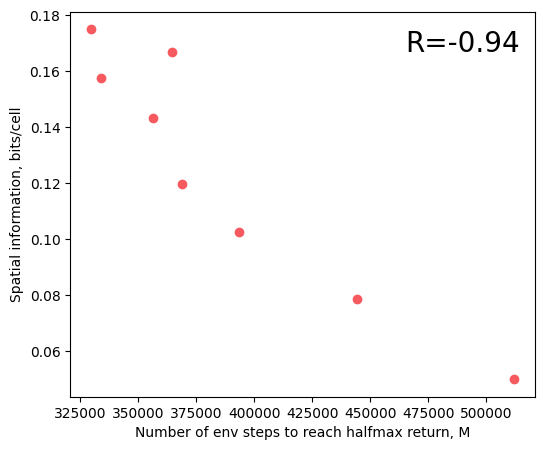

In [16]:
# CANN
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(frames, SI,
           color=CLRS['salmon']
        #    color=[CLRS['salmon'],CLRS['coal'],CLRS['magenta'],CLRS['cyan'],CLRS['orange'],CLRS['mint'],CLRS['coral'],CLRS['grey']]
           )
# ax.set_facecolor(CLRS['beige'])
plt.ylabel('Spatial information, bits/cell')
plt.xlabel('Number of env steps to reach halfmax return, M')
plt.text(465000, 0.167, 'R=-0.94', fontsize=20)
# plt.xlim(1)
# plt.yticks(np.arange(0,1.1,0.1))
# plt.legend(('SD=1', 'SD=2', 'SD=3', 'SD=4', 'SD=5', 'SD=6'), loc=4)
plt.show()
fig.savefig('Figures/SI_speed_CANN.png', transparent=True)

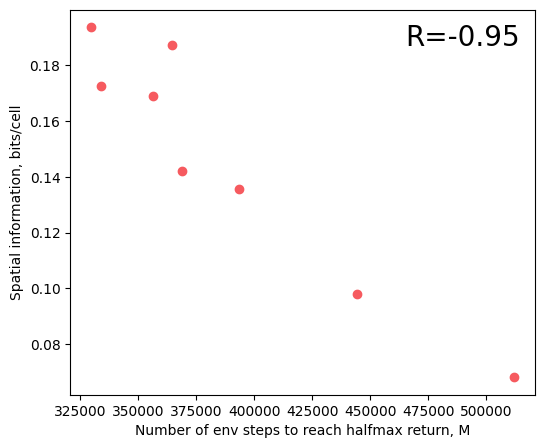

In [23]:
# CANN builtin
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(frames, SI,
           color=CLRS['salmon']
        #    color=[CLRS['salmon'],CLRS['coal'],CLRS['magenta'],CLRS['cyan'],CLRS['orange'],CLRS['mint'],CLRS['coral'],CLRS['grey']]
           )
# ax.set_facecolor(CLRS['beige'])
plt.ylabel('Spatial information, bits/cell')
plt.xlabel('Number of env steps to reach halfmax return, M')
plt.text(465000, 0.187, 'R=-0.95', fontsize=20)
# plt.xlim(1)
# plt.yticks(np.arange(0,1.1,0.1))
# plt.legend(('SD=1', 'SD=2', 'SD=3', 'SD=4', 'SD=5', 'SD=6'), loc=4)
plt.show()
fig.savefig('Figures/SI_speed_CANN.png', transparent=True)

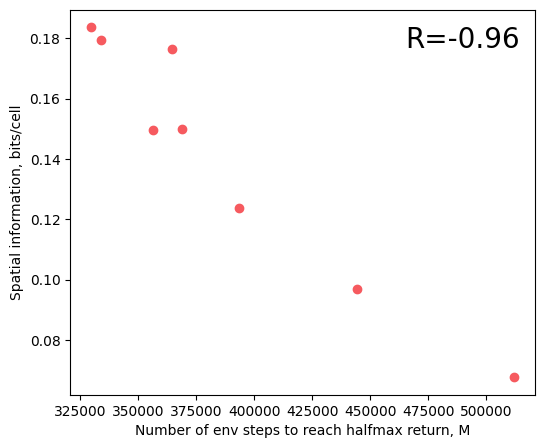

In [28]:
# CANN builtin_nonorm
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(frames, SI,
           color=CLRS['salmon']
        #    color=[CLRS['salmon'],CLRS['coal'],CLRS['magenta'],CLRS['cyan'],CLRS['orange'],CLRS['mint'],CLRS['coral'],CLRS['grey']]
           )
# ax.set_facecolor(CLRS['beige'])
plt.ylabel('Spatial information, bits/cell')
plt.xlabel('Number of env steps to reach halfmax return, M')
plt.text(465000, 0.177, 'R=-0.96', fontsize=20)
# plt.xlim(1)
# plt.yticks(np.arange(0,1.1,0.1))
# plt.legend(('SD=1', 'SD=2', 'SD=3', 'SD=4', 'SD=5', 'SD=6'), loc=4)
plt.show()
fig.savefig('Figures/SI_speed_CANN.png', transparent=True)

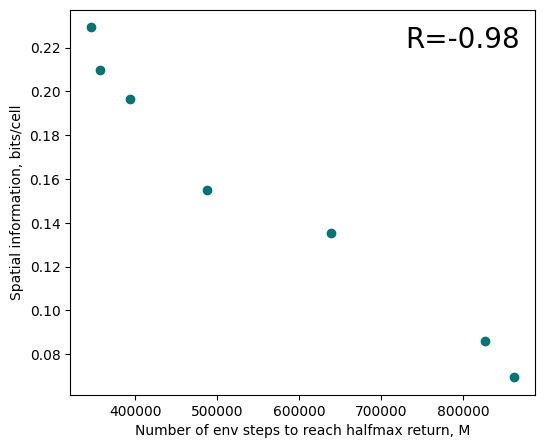

In [25]:
# PC
fig, ax = plt.subplots(figsize=(6,5))
ax.scatter(frames, SI[:-1],
           color=CLRS['cyan']
        #    color=[CLRS['salmon'],CLRS['coal'],CLRS['magenta'],CLRS['cyan'],CLRS['orange'],CLRS['mint'],CLRS['coral'],CLRS['grey']]
           )
# ax.set_facecolor(CLRS['beige'])
plt.ylabel('Spatial information, bits/cell')
plt.xlabel('Number of env steps to reach halfmax return, M')
plt.text(730000, 0.22, 'R=-0.98', fontsize=20)
# plt.xlim(1)
# plt.yticks(np.arange(0,1.1,0.1))
# plt.legend(('SD=1', 'SD=2', 'SD=3', 'SD=4', 'SD=5', 'SD=6'), loc=4)
plt.show()
fig.savefig('Figures/SI_speed_PC.png', transparent=True)

In [6]:
def make_grid(sd):
    fake_pc = RLutils.FakePlaceCells(env, 300, sd)
    grid = np.zeros((300, 23*17))
    for i in range(23):
        for j in range(17):
            response = fake_pc.activation((i+1,j+1))
            grid[:,i*17+j] = response
    return grid

In [3]:
pos = np.vstack((np.indices((23,17))[0].flatten(),np.indices((23,17))[1].flatten())).T

In [17]:
import pynapple as nap

def create_tds(cell, sd, pos):
    grid = make_grid(sd)
    position = nap.TsdFrame(t = np.arange(23*17),
                            d = pos,
                            columns = ('x','y'), time_units = 'ms')
    rates = nap.TsdFrame(t = np.arange(23*17),
                         d = grid.T, time_units = 'ms')
    place_fields,xy = nap.compute_2d_tuning_curves_continuous(rates,position,
                                                                ep=rates.time_support,
                                                                nb_bins=(env.grid.width-2, env.grid.height-2),
                                                                minmax=(0, env.grid.width-2,
                                                                        0, env.grid.height-2)
                                                                )
    return place_fields

In [18]:
pf1 = create_tds(0,1,pos)
pf2 = create_tds(0,2,pos)
pf3 = create_tds(0,3,pos)
pf4 = create_tds(0,4,pos)
pf5 = create_tds(0,6,pos)
pf6 = create_tds(0,8,pos)
pf7 = create_tds(0,10,pos)
pf8 = create_tds(0,12,pos)

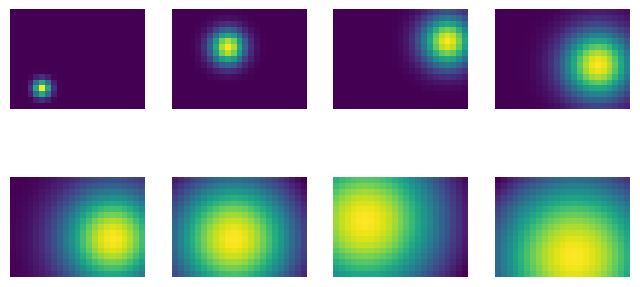

In [19]:
fig = plt.figure(figsize=(8,4))
axs = fig.subplots(2,4)
axs[0,0].imshow(pf1[0].transpose(), interpolation='nearest')
axs[0,0].axis('off')
axs[0,1].imshow(pf2[1].transpose(), interpolation='nearest')
axs[0,1].axis('off')
axs[0,2].imshow(pf3[2].transpose(), interpolation='nearest')
axs[0,2].axis('off')
axs[0,3].imshow(pf4[3].transpose(), interpolation='nearest')
axs[0,3].axis('off')
axs[1,0].imshow(pf5[12].transpose(), interpolation='nearest')
axs[1,0].axis('off')
axs[1,1].imshow(pf6[9].transpose(), interpolation='nearest')
axs[1,1].axis('off')
axs[1,2].imshow(pf7[14].transpose(), interpolation='nearest')
axs[1,2].axis('off')
axs[1,3].imshow(pf8[11].transpose(), interpolation='nearest')
axs[1,3].axis('off')
plt.show()
# fig.savefig('storage/figs/place_fields.png', transparent=True)

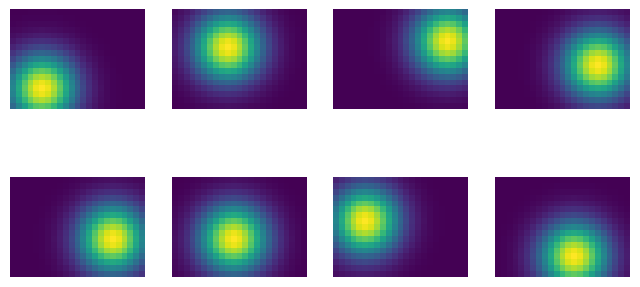

In [22]:
fig = plt.figure(figsize=(8,4))
axs = fig.subplots(2,4)
axs[0,0].imshow(pf1[0].transpose(), interpolation='nearest')
axs[0,0].axis('off')
axs[0,1].imshow(pf1[1].transpose(), interpolation='nearest')
axs[0,1].axis('off')
axs[0,2].imshow(pf1[2].transpose(), interpolation='nearest')
axs[0,2].axis('off')
axs[0,3].imshow(pf1[3].transpose(), interpolation='nearest')
axs[0,3].axis('off')
axs[1,0].imshow(pf1[12].transpose(), interpolation='nearest')
axs[1,0].axis('off')
axs[1,1].imshow(pf1[9].transpose(), interpolation='nearest')
axs[1,1].axis('off')
axs[1,2].imshow(pf1[14].transpose(), interpolation='nearest')
axs[1,2].axis('off')
axs[1,3].imshow(pf1[11].transpose(), interpolation='nearest')
axs[1,3].axis('off')
plt.show()
fig.savefig('Figures/place_fields_size4.png', transparent=True)